In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
from torch import nn

sys.path.append('../src')
from base import buildmethod, HotTopic
from qae import QAE
from nets import OPTIM, MLP
from sim import make_dataset
from utils import get_kwargs, show_dataset, shuffle

### Nonparametric Quantized Autoencoder

In [97]:
class NQA(HotTopic, nn.Module):
    def __init__(self, channels=(64, 32), optim='adam', desc='NQA', random_state=None):
        super().__init__(desc, random_state)

        self.channels = channels
        self.optim = optim

        self._n_steps = 100

    def _build(self, X, learning_rate=1e-4, weight_decay=1e-2):
        self._n_samples, in_channels = X.shape
        out_channels = (self.channels,) if isinstance(self.channels, int) else self.channels
        self._encoder = MLP(in_channels, *out_channels, act_layer='relu')
        self._decoder = MLP(*out_channels[::-1], in_channels, act_layer='relu')
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def _assign(self, z, i, update_codebook=False, return_loss=False):
        cdist = (z[i] - self._codebook).square().sum(-1)
        loss, topic = cdist.min(-1)

        if update_codebook and topic + 1 == self.n_topics_:
            new_code = z[torch.randperm(self._n_samples - i)[0] + i].detach()[None]
            self._codebook = torch.cat((self._codebook, new_code))
            self.n_topics_ += 1

        if return_loss:
            return topic, loss
        return topic
    
    def _quantize(self, z, return_loss=False):
        self._codebook, self.n_topics_ = z[:1].detach(), 1
        topics = torch.zeros(self._n_samples, dtype=torch.int32)
        loss = (z[0] - self._codebook).square().sum()

        # for i in range(1, self._n_samples):
        #     self._assign(z, i, update_codebook=True)

        for i in range(1, self._n_samples):
            topics[i], z_loss = self._assign(z, i, update_codebook=True, return_loss=True)
            loss += z_loss

        if return_loss:
            return topics, loss
        return topics
    
    def _evaluate(self, X, z):
        topics, loss = self._quantize(z, return_loss=True)
        codes = self._codebook[topics]
        X_ = self._decoder(codes)
        loss += (X_ - X).square().sum()

        return loss
    
    def _step(self, X):
        z = self._encoder(X)
        loss = self._evaluate(X, z)
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()

        return loss.item()
    
    def _predict(self, X):
        z = self._encoder(X)
        topics = self._quantize(z)

        return topics

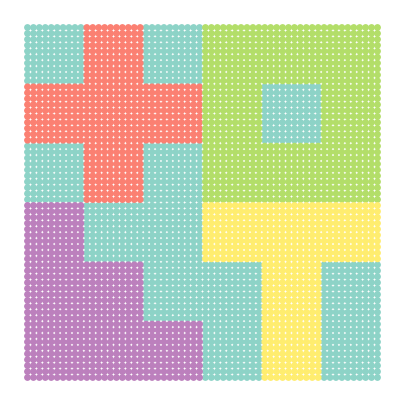

In [98]:
data, labels = make_dataset(return_tensor=True)
show_dataset(data, labels)

NQA: 100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]


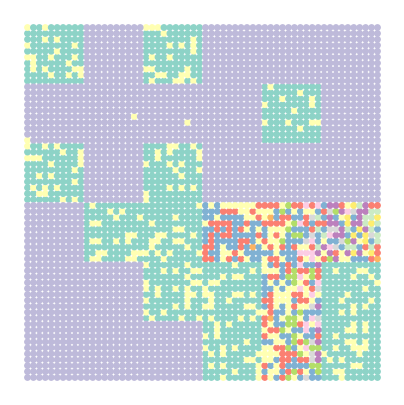

In [99]:
model = NQA()
topics = model.fit_predict(data[:, 3:], n_steps=1000)
show_dataset(data, topics)

topics: 24


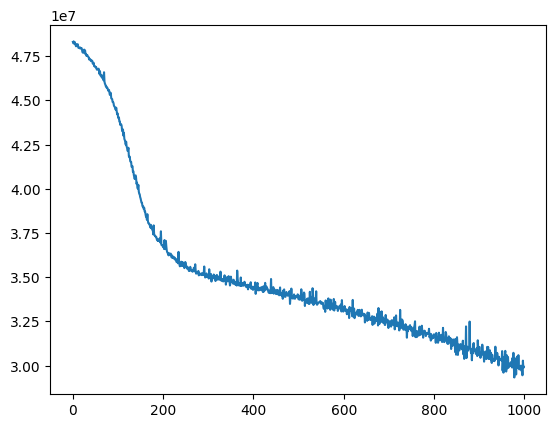

In [100]:
print('topics:', model.n_topics_)
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()

### Unsupervised Neural Clustering Process

In [2]:
class Encoder(nn.Module):
    def __init__(self, in_channels, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), cb_channels=32, act_layer='prelu'):
        super().__init__()

        self.in_channels = in_channels
        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.cb_channels = cb_channels
        self.act_layer = act_layer

        if self.lp_channels[-1] != 1:
            self.lp_channels += (1,)

        self._wc_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._us_model = MLP(self.in_channels, *self.wc_channels, act_layer=self.act_layer)
        self._bc_model = MLP(self.wc_channels[-1], *self.bc_channels, act_layer=self.act_layer)
        self._lp_model = MLP(self.wc_channels[-1] + self.bc_channels[-1], *self.lp_channels, act_layer=self.act_layer, final_bias=False)
        self._codes = 100.*torch.rand((1000, self.cb_channels))

    def _build(self, X):
        self._n_samples, self.n_topics_ = X.shape[0], 1
        self._topic_range = torch.arange(self.n_topics_)
        self._wc, self._us = self._wc_model(X), self._us_model(X)
        self._WC = torch.zeros((1, self.wc_channels[-1]))
        self._WC[0], self._US = self._wc[:1], self._us[2:].sum(0)
        self._codebook = self._codes[:2]

        return self
    
    def _update(self, idx, topics):
        n_topics = topics[:idx].unique().shape[0]

        if n_topics == self.n_topics_:
            self._WC[topics[idx - 1]] += self._wc[idx - 1]
        else:
            self._WC = torch.cat((self._WC, self._wc[idx - 1].unsqueeze(0)))
            self._codebook = torch.cat((self._codebook, self._codes[idx + 1:idx + 2]))

        if idx == self._n_samples - 1:
            self._US = torch.zeros(self.wc_channels[-1])
        else:
            self._US -= self._us[idx]

        self.n_topics_, self._topic_range = n_topics, torch.arange(n_topics)

        return n_topics
    
    def _logprobs(self, idx):
        WC_k = self._WC.repeat(self.n_topics_, 1, 1)
        WC_k[self._topic_range, self._topic_range] += self._wc[idx]
        WC_K = torch.cat((self._WC, self._wc[idx].unsqueeze(0)))
        BC_k, BC_K = self._bc_model(WC_k).sum(1), self._bc_model(WC_K).sum(0)
        US_k = self._US.repeat(self.n_topics_, 1)
        logprobs = torch.zeros(self.n_topics_ + 1)
        logprobs[:-1] = self._lp_model(torch.cat((BC_k, US_k), -1))[..., 0].T
        logprobs[-1] = self._lp_model(torch.cat((BC_K, self._US))).squeeze()
        m, _ = logprobs.max(0, keepdim=True)
        logprobs = logprobs - m - (logprobs - m).exp().sum(0, keepdim=True).log()

        return logprobs
    
    @buildmethod
    def forward(self, X, return_codes=False):
        topics = torch.zeros(self._n_samples, dtype=torch.int32)
        z = torch.zeros((self._n_samples, self.cb_channels))

        for i in range(1, self._n_samples):
            self._update(i, topics)
            logprobs = self._logprobs(i)
            topics[i] = logprobs.argmax()
            z[i] = torch.normal(self._codebook[topics[i]], 1.)

        if return_codes:
            return z
        return topics
    
class UCP(HotTopic, nn.Module):
    def __init__(self, wc_channels=(128, 128), bc_channels=(512, 512), lp_channels=(128, 128), cb_channels=32, act_layer='prelu', optim='adam', desc='UCP', random_state=None):
        super().__init__(desc, random_state)

        self.wc_channels = wc_channels
        self.bc_channels = bc_channels
        self.lp_channels = lp_channels
        self.cb_channels = cb_channels
        self.act_layer = act_layer
        self.optim = optim

        self._n_steps = 200

    def _build(self, X, learning_rate=1e-2, weight_decay=1e-2):
        self._n_samples, self._in_channels = X.shape
        self._encoder = Encoder(self._in_channels, self.wc_channels, self.bc_channels, self.lp_channels, self.cb_channels, self.act_layer)
        self._decoder = MLP(self.cb_channels, *self.lp_channels[::-1], self._in_channels, act_layer=self.act_layer)
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)

        return self
    
    def _evaluate(self, X):
        z = self._encoder(X, return_codes=True)
        X_ = self._decoder(z)
        loss = (X_ - X).square().sum()

        return loss
    
    def _step(self, X):
        loss = self._evaluate(X)
        loss.backward()
        self._optim.step()
        self._optim.zero_grad()

        return loss.item()
    
    def _predict(self, X):
        topics = self._encoder(X)

        return topics

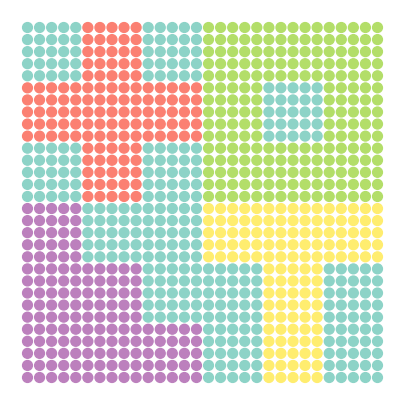

In [4]:
data, labels = make_dataset(block_size=5, topic_sep=100, return_tensor=True)
show_dataset(data, labels, size=50)

UCP: 100%|██████████| 200/200 [01:46<00:00,  1.88it/s]


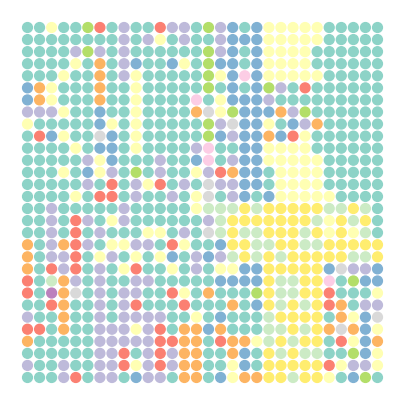

In [74]:
model = UCP()
topics = model.fit_predict(data[:, 3:], n_steps=200)
show_dataset(data, topics, size=50)

topics: 19


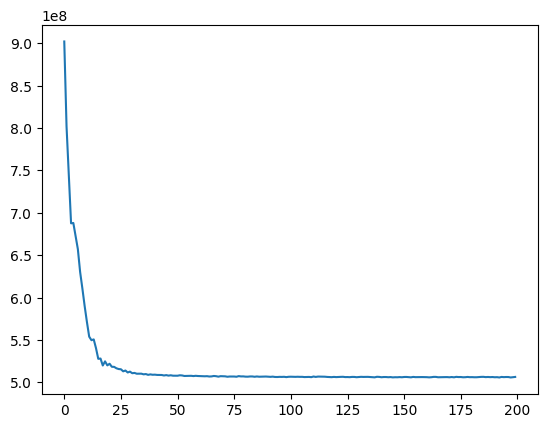

In [75]:
print('topics:', model._encoder.n_topics_)
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()

### PriorLDA

In [64]:
class PriorLDA(HotTopic, nn.Module):
    def __init__(self, *, h_channels=(128, 128), g_channels=(512, 512), f_channels=(128, 64, 32), optim='adam', desc='PriorLDA', random_state=None):
        super().__init__(desc, random_state)

        self.h_channels = h_channels
        self.g_channels = g_channels
        self.f_channels = f_channels
        self.optim = optim

        self._n_steps = 200

    def _build(self, X, learning_rate=1e-4, weight_decay=1e-2):
        self._in_channels = X.shape[-1]
        self._h_model = MLP(self._in_channels, *self.h_channels, act_layer='prelu')
        self._u_model = MLP(self._in_channels, *self.h_channels, act_layer='prelu')
        self._g_model = MLP(self.h_channels[-1], *self.g_channels, act_layer='prelu')
        self._f_model = MLP(self.h_channels[-1] + self.g_channels[-1], *self.f_channels, act_layer='prelu')
        self._decoder = MLP(*self.f_channels[::-1], *self.h_channels[::-1], self._in_channels, act_layer='prelu')
        self._optim = OPTIM[self.optim](self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        return self

    def _reset(self, X):
        self._batch_size, self.n_topics_ = X.shape[0], 1
        self._topic_range = torch.arange(self.n_topics_)
        self._h, self._u = self._h_model(X), self._u_model(X)
        self._H = torch.zeros((1, self.h_channels[-1]))
        self._H[0], self._U = self._h[:1], self._u[1:].sum(0)

        return self
    
    def _update(self, idx, topics):
        n_topics = topics[:idx].unique().shape[0]

        if n_topics == self.n_topics_:
            self._H[topics[idx - 1]] += self._h[idx - 1]
        else:
            self._H = torch.cat((self._H, self._h[idx - 1].unsqueeze(0)))

        self.n_topics_, self._topic_range = n_topics, torch.arange(n_topics)

        if idx == self._batch_size - 1:
            self._U = torch.zeros(self.h_channels[-1])
        else:
            self._U -= self._u[idx]

        return n_topics
    
    def _encode(self, idx):
        H_k = self._H.repeat(self.n_topics_, 1, 1)
        H_k[self._topic_range, self._topic_range] += self._h[idx]
        H_K = torch.cat((self._H, self._h[idx].unsqueeze(0)))
        G_k, G_K = self._g_model(H_k).sum(1), self._g_model(H_K).sum(0)
        U_k = self._U.repeat(self.n_topics_, 1)
        codes = torch.zeros((self.n_topics_ + 1, self.f_channels[-1]))
        codes[:-1] = self._f_model(torch.cat((G_k, U_k), -1))
        codes[-1] = self._f_model(torch.cat((G_K, self._U)))

        return codes
            
    def _evaluate(self, X, return_loss=False):
        self._reset(X)  # FIXME
        topics = torch.zeros(self._batch_size, dtype=torch.int32)
        loss = 0
        
        for i in range(1, self._batch_size):  # TODO: add variational component?
            self._update(i, topics)
            codes = self._encode(i)
            dists = (X[i, None] - self._decoder(codes)).square().sum(-1).sqrt()
            topics[i] = dists.argmin()
            loss += dists[topics[i]] # TODO: encourage like-topic codes to be similar

        if return_loss:
            return loss
        return topics

    def _step(self, X, n_perms=6, n_samples=64):
        loss = 0

        for _ in range(n_perms):
            data = shuffle(X, cut=n_samples)
            perm_loss = self._evaluate(data, return_loss=True)
            perm_loss.backward()
            loss += perm_loss.item()

        # loss = self._evaluate(X, return_loss=True)
        # loss.backward()
            self._optim.step()
            self._optim.zero_grad()

        return loss

    def _predict(self, X):
        topics = self._evaluate(X)

        return topics

    # @buildmethod  TODO: add parameter
    # def forward(self, X, *, return_codes=False):
    #     self._reset(X)  # FIXME

    #     topics = torch.zeros(self._batch_size)

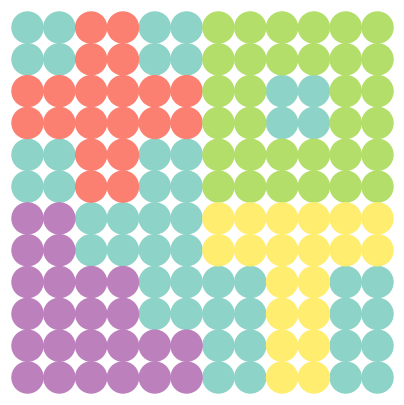

In [65]:
data, labels = make_dataset(block_size=2, return_tensor=True)
show_dataset(data, labels, size=500)

In [76]:
rnn = nn.RNN(data.shape[-1], 50, 3)
h0 = torch.randn(3, 50)
rnn(data, h0)

(tensor([[-0.0834, -0.4918, -0.9736,  ..., -0.3567, -0.6052,  0.8043],
         [ 0.6112, -0.0315, -0.0018,  ...,  0.5529,  0.5048,  0.6020],
         [ 0.2197, -0.4306, -0.2373,  ...,  0.0461,  0.3179,  0.2148],
         ...,
         [ 0.1018, -0.3997, -0.2021,  ...,  0.3742, -0.2227,  0.1462],
         [ 0.1715, -0.2549, -0.0951,  ...,  0.2119, -0.1419, -0.0577],
         [ 0.3539,  0.0597, -0.1932,  ..., -0.1217, -0.2315, -0.1242]],
        grad_fn=<SqueezeBackward1>),
 tensor([[ 1.0000, -1.0000, -1.0000, -1.0000, -1.0000,  0.9829, -1.0000,  0.9983,
           1.0000, -0.9998, -1.0000,  1.0000, -1.0000,  1.0000, -0.9949,  1.0000,
          -0.9876, -1.0000, -1.0000,  1.0000, -1.0000,  0.9999, -1.0000, -1.0000,
          -0.5947, -0.9866, -0.9490, -0.9999, -0.7363, -0.9828,  0.9987,  1.0000,
           1.0000, -1.0000,  0.8660,  1.0000,  0.9966,  1.0000,  1.0000, -0.9993,
          -1.0000,  1.0000,  1.0000, -1.0000, -0.9907, -0.9967, -1.0000,  1.0000,
           0.9348,  1.0000],
 

PriorLDA: 100%|██████████| 1000/1000 [13:10<00:00,  1.27it/s]


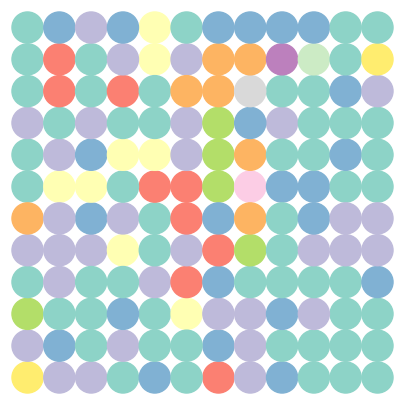

In [66]:
model = PriorLDA()
topics = model.fit_predict(data[:, 3:], n_steps=1000)
show_dataset(data, topics, size=500)

topics: 15


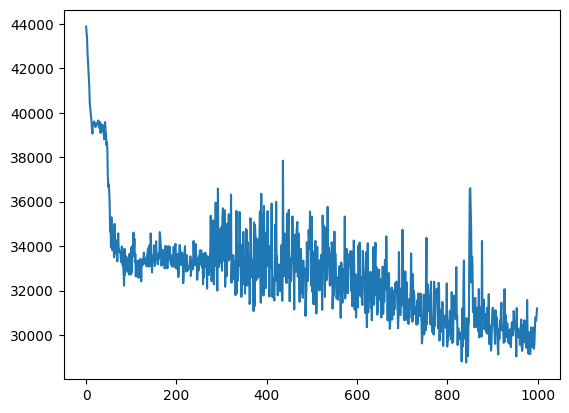

In [67]:
print('topics:', model.n_topics_)
arr = torch.arange(len(model.log_))
plt.plot(arr, model.log_)
plt.show()